<a href="https://colab.research.google.com/github/IsaacFigNewton/Analyzing-Hate-Crime-Data/blob/main/Hate_Crime_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO:
####Get p-values for different correlation coefficients in merged_df
####Extract county-by-county hate crime frequency data

#Import Stuff

###Import all libraries

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt
import re

###Import datasets

In [2]:
crime_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/hate_crime/hate_crime.csv", on_bad_lines='skip')
county_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ACSDP1Y2022.DP05-Data.csv", on_bad_lines='skip')

In [3]:
ethnicity_race_cols = list(set(pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ethnicity_race_col_names", sep=";")["Percent!!RACE!!One race"]))
# ethnicity_race_cols

#Data Cleaning

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
#only consider 2022 crime data from cities and counties
crime_df = crime_df[(crime_df['data_year'] == 2022) & ((crime_df['agency_type_name'] == "County"))]

##Clean county demographic dataset

In [6]:
# use the entries of the first row as the column headers for easier management
def fixHeaders(df):
  new_headers = df.iloc[0]
  new_df = df[1:]
  new_df.columns = new_headers
  return new_df

In [7]:
#fix the headers
county_demo_df = fixHeaders(county_demo_df)

###Create area columns

In [8]:
def split_area_name(area):
    result = [np.nan, np.nan, np.nan]
    if ", " in area:
        result = area.split(", ") + [np.nan]
    if " city" in result[0].lower():
        result[0] = result[0][0:-5]
        result[2] = result[1]
        result[1] = "City"
    elif " county" in result[0].lower():
        result[0] = result[0][0:-7]
        result[2] = result[1]
        result[1] = "County"

    return result + [np.nan] * (3 - len(result))

def splitArea(df):
    df[["pug_agency_name", "agency_type_name", "state_name"]] = df["Geographic Area Name"].map(split_area_name).apply(pd.Series)

In [9]:
splitArea(county_demo_df)

###Fix column names



In [10]:
def fix_column_names(df):
  removalList = {"SEX AND AGE!!", "SEX AND ", "Estimate!!", "Total!!", "Total population!!", "CITIZEN, VOTING AGE POPULATION!!", "AGE!!"}

  new_cols = []
  for col in df.columns:
    col = str(col)
    for term in removalList:
      if term in col:
        col = col.replace(term, "")
    new_cols.append(col)

  return new_cols

county_demo_df.columns = fix_column_names(county_demo_df)

###Remove irrelevant/bad columns and rows to line the dataframes up

In [11]:
# fix any missing values
county_demo_df = county_demo_df.replace("(X)", np.nan)

In [12]:
#drop all margin of error columns from the county dataframe
def drop_cols_containing(df, pattern):
    df.drop(columns=list(df.filter(regex = pattern)), inplace = True)

drop_cols_containing(county_demo_df, "Margin of Error|SUMMARY INDICATORS|PERCENT ALLOCATED")

In [13]:
# Drop columns that only contain NaN values
new_county_df = county_demo_df.dropna(how='all', axis=1)

# get a list of the cols in the original df that aren't in the new one
dropped_cols = (set(county_demo_df.columns)).difference(set(new_county_df.columns))

# remove the deleted columns from ethnicity_race_cols
ethnicity_race_cols = list((set(ethnicity_race_cols)).difference(set(dropped_cols)))

county_demo_df = new_county_df

print(ethnicity_race_cols)

# Drop rows with NaN values in any of the ethnicity_race_cols
county_demo_df.dropna(subset=ethnicity_race_cols, how='any', inplace=True)

['Percent!!HISPANIC OR LATINO AND RACE!!Total population', 'Percent!!RACE!!Two or More Races!!White and Some Other Race', 'Percent!!RACE!!Two or More Races!!Black or African American and Some Other Race', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races excluding Some Other Race, and three or more races', 'Percent!!RACE!!Two or More Races!!Black or African American and American Indian and Alaska Native', 'Percent!!RACE!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping', 'Percent!!RACE!!One race!!White', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races', 'Percent!!RACE!!Two or More Races', 'Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Puerto Rican', 'Percent!!Citizen, 18 and over population', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Some Other Race alone', 'Percent!!Race alone or i

<ipython-input-13-1911c076593c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_demo_df.dropna(subset=ethnicity_race_cols, how='any', inplace=True)


###Fix column data types

In [14]:
counts = county_demo_df.columns.value_counts()
mask = counts > 1
duplicates = list(counts[mask].index)
county_demo_df[duplicates].dtypes

RACE!!Two or More Races             object
RACE!!Two or More Races             object
65 years and over                   object
65 years and over                   object
18 years and over                   object
18 years and over                   object
Percent!!65 years and over          object
Percent!!65 years and over          object
Percent!!18 years and over          object
Percent!!18 years and over          object
Percent!!RACE!!One race             object
Percent!!RACE!!One race             object
Percent!!RACE!!Two or More Races    object
Percent!!RACE!!Two or More Races    object
RACE!!One race                      object
RACE!!One race                      object
dtype: object

In [15]:
county_demo_df = county_demo_df.loc[:, ~county_demo_df.columns.duplicated(keep='last')]

In [16]:
county_percent_age_cols = list(set(list(county_demo_df.filter(regex = "Percent")) + list(county_demo_df.filter(regex = "ratio")) + list(county_demo_df.filter(regex = "years"))))

for column in county_percent_age_cols:
    county_demo_df = county_demo_df[~county_demo_df[column].astype(str).str.contains('N')]

In [17]:
county_demo_df[county_percent_age_cols] = county_demo_df[county_percent_age_cols].astype(float)

In [18]:
county_demo_df[ethnicity_race_cols] = county_demo_df[ethnicity_race_cols].astype(float)

In [19]:
# Convert the quantitative columns to int types
# continuous quantitative variables
continuous_int_columns = ["Total population", "Under 5 years", "5 to 9 years", "45 to 54 years", "10 to 14 years", "75 to 84 years", "60 to 64 years",\
                      "25 to 34 years", "15 to 19 years", "20 to 24 years", "35 to 44 years", "55 to 59 years", "65 to 74 years",\
                      "85 years and over"]

for column in continuous_int_columns:
    county_demo_df = county_demo_df[~county_demo_df[column].astype(str).str.contains('N')]

county_demo_df[continuous_int_columns] = county_demo_df[continuous_int_columns].astype(int)

In [20]:
age_groups = ['Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years', '55 to 59 years', '60 to 64 years', '65 to 74 years', '75 to 84 years', '85 years and over']

##Clean crime dataset

###Break up incident date information

In [21]:
def split_incident_date(date):
    result = date.split("-")

    return result + [np.nan] * (3 - len(result))

crime_df[["data_year", "incident_month", "incident_day"]] = crime_df["incident_date"]\
                                                              .map(split_incident_date)\
                                                              .apply(pd.Series)\
                                                              .astype(int)

In [22]:
crime_df[["data_year", "incident_month", "incident_day"]].dtypes

data_year         int64
incident_month    int64
incident_day      int64
dtype: object

###Break up crime_df categorical columns containing multiple categories into dummies

In [23]:
def multicol_parse(df, column, delimiter):
  prefix = column + "_"

  dummies = df[column]\
              .str\
              .get_dummies(sep=delimiter)\
              .add_prefix(prefix)
  dummies = dummies.astype(int)
  dummies.head()

  dummy_cols = list(dummies.columns)
  unique_values = [val.replace(prefix, "") for val in dummy_cols]

  # combine the dataframes
  new_df = pd.concat([df, dummies], axis=1)

  return unique_values, dummy_cols, new_df

In [24]:
crime_df.reset_index(inplace=True)

In [25]:
#Break up bias_desc column into dummy columns
unique_biases, bias_cols, crime_df = multicol_parse(crime_df, "bias_desc", ";")

In [26]:
#Break up victim_types column into dummy columns
unique_victim_types, victim_cols, crime_df = multicol_parse(crime_df, "victim_types", ";")

In [27]:
#Break up offense_names column into dummy columns
unique_offense_names, offense_cols, crime_df = multicol_parse(crime_df, "offense_name", ";")

In [28]:
#Break up location_names column into dummy columns
unique_location_names, location_cols, crime_df = multicol_parse(crime_df, "location_name", ";")

###Create dummy columns for other categorical variables

In [29]:
other_categorical_cols = ["agency_type_name", "division_name", "offender_race", "offender_ethnicity",
                            "state_name", "multiple_offense", "multiple_bias"]

In [30]:
other_unique_categorical_col_vals = {}
for col in other_categorical_cols:
    other_unique_categorical_col_vals[col] = crime_df[col].unique()


In [31]:
dummies = pd.get_dummies(crime_df[other_categorical_cols]).astype(int)
dummies.drop(columns=['multiple_offense_S', 'multiple_bias_S'], inplace=True)

other_categorical_cols = dummies.columns

# combine the dummy columns with crime_df
crime_df = pd.concat([crime_df, dummies], axis=1)

##Merge the datasets

In [32]:
# combine the crime and population datasets
merged_df = pd.merge(crime_df, county_demo_df, on=["pug_agency_name", "agency_type_name", "state_name"])

In [33]:
merged_df.drop(["ori", "state_abbr", "population_group_code", "pub_agency_unit",
                "Geography", "Percent!!Total population", "population_group_description",
                "Geographic Area Name", "incident_date", "pub_agency_unit", "pug_agency_name",
                "agency_type_name", "state_name", "division_name", "offender_race", "offender_ethnicity",
                "location_name", "bias_desc", "victim_types", "multiple_offense",
                  "multiple_bias"], axis=1, inplace=True)

# include offense_name in categorical data once you've refactored multicol parsing

In [34]:
# categorical variables
binary_int_columns = bias_cols + victim_cols + offense_cols + location_cols + list(other_categorical_cols)
int_columns = continuous_int_columns + binary_int_columns + ["incident_month", "incident_day"]

In [35]:
print(int_columns)

['Total population', 'Under 5 years', '5 to 9 years', '45 to 54 years', '10 to 14 years', '75 to 84 years', '60 to 64 years', '25 to 34 years', '15 to 19 years', '20 to 24 years', '35 to 44 years', '55 to 59 years', '65 to 74 years', '85 years and over', 'bias_desc_Anti-American Indian or Alaska Native', 'bias_desc_Anti-Arab', 'bias_desc_Anti-Asian', 'bias_desc_Anti-Atheism/Agnosticism', 'bias_desc_Anti-Bisexual', 'bias_desc_Anti-Black or African American', 'bias_desc_Anti-Buddhist', 'bias_desc_Anti-Catholic', 'bias_desc_Anti-Church of Jesus Christ', 'bias_desc_Anti-Eastern Orthodox (Russian, Greek, Other)', 'bias_desc_Anti-Female', 'bias_desc_Anti-Gay (Male)', 'bias_desc_Anti-Gender Non-Conforming', 'bias_desc_Anti-Heterosexual', 'bias_desc_Anti-Hindu', 'bias_desc_Anti-Hispanic or Latino', 'bias_desc_Anti-Islamic (Muslim)', "bias_desc_Anti-Jehovah's Witness", 'bias_desc_Anti-Jewish', 'bias_desc_Anti-Lesbian (Female)', 'bias_desc_Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group

#Extract Additional Features

In [36]:
def get_col_counts(df, unique_cols):
    # get the frequencies of categorical data based
    unique_col_counts = {}
    for value in unique_cols:
        unique_col_counts[value] = df[value].sum()

    return unique_col_counts

##Get hate crime rate per state

In [37]:
merged_df.head()

,index,incident_id,data_year,region_name,adult_victim_count,juvenile_victim_count,total_offender_count,adult_offender_count,juvenile_offender_count,victim_count,offense_name,total_individual_victims,incident_month,incident_day,bias_desc_Anti-American Indian or Alaska Native,bias_desc_Anti-Arab,bias_desc_Anti-Asian,bias_desc_Anti-Atheism/Agnosticism,bias_desc_Anti-Bisexual,bias_desc_Anti-Black or African American,bias_desc_Anti-Buddhist,bias_desc_Anti-Catholic,bias_desc_Anti-Church of Jesus Christ,"bias_desc_Anti-Eastern Orthodox (Russian, Greek, Other)",bias_desc_Anti-Female,bias_desc_Anti-Gay (Male),bias_desc_Anti-Gender Non-Conforming,bias_desc_Anti-Heterosexual,bias_desc_Anti-Hindu,bias_desc_Anti-Hispanic or Latino,bias_desc_Anti-Islamic (Muslim),bias_desc_Anti-Jehovah's Witness,bias_desc_Anti-Jewish,bias_desc_Anti-Lesbian (Female),"bias_desc_Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)",bias_desc_Anti-Male,bias_desc_Anti-Mental Disability,"bias_desc_Anti-Multiple Races, Group","bias_desc_Anti-Multiple Religions, Group",bias_desc_Anti-Native Hawaiian or Other Pacific Islander,bias_desc_Anti-Other Christian,bias_desc_Anti-Other Race/Ethnicity/Ancestry,bias_desc_Anti-Other Religion,bias_desc_Anti-Physical Disability,bias_desc_Anti-Protestant,bias_desc_Anti-Sikh,bias_desc_Anti-Transgender,bias_desc_Anti-White,victim_types_Business,victim_types_Government,victim_types_Individual,victim_types_Law Enforcement Officer,victim_types_Other,victim_types_Religious Organization,victim_types_Society/Public,offense_name_Aggravated Assault,offense_name_All Other Larceny,offense_name_Animal Cruelty,offense_name_Arson,offense_name_Burglary/Breaking & Entering,offense_name_Counterfeiting/Forgery,offense_name_Credit Card/Automated Teller Machine Fraud,offense_name_Destruction/Damage/Vandalism of Property,offense_name_Drug Equipment Violations,offense_name_Drug/Narcotic Violations,offense_name_Extortion/Blackmail,offense_name_False Pretenses/Swindle/Confidence Game,offense_name_Fondling,"offense_name_Human Trafficking, Involuntary Servitude",offense_name_Identity Theft,offense_name_Impersonation,offense_name_Intimidation,offense_name_Kidnapping/Abduction,offense_name_Motor Vehicle Theft,offense_name_Murder and Nonnegligent Manslaughter,offense_name_Not Specified,offense_name_Pocket-picking,offense_name_Pornography/Obscene Material,offense_name_Rape,offense_name_Robbery,offense_name_Sexual Assault With An Object,offense_name_Shoplifting,offense_name_Simple Assault,offense_name_Sodomy,offense_name_Statutory Rape,offense_name_Stolen Property Offenses,offense_name_Theft From Building,offense_name_Theft From Motor Vehicle,offense_name_Theft of Motor Vehicle Parts or Accessories,offense_name_Weapon Law Violations,offense_name_Wire Fraud,location_name_Abandoned/Condemned Structure,location_name_Air/Bus/Train Terminal,location_name_Amusement Park,location_name_Arena/Stadium/Fairgrounds/Coliseum,location_name_Auto Dealership New/Used,location_name_Bank/Savings and Loan,location_name_Bar/Nightclub,location_name_Camp/Campground,location_name_Church/Synagogue/Temple/Mosque,location_name_Commercial/Office Building,location_name_Community Center,location_name_Construction Site,location_name_Convenience Store,location_name_Cyberspace,location_name_Daycare Facility,location_name_Department/Discount Store,location_name_Dock/Wharf/Freight/Modal Terminal,location_name_Drug Store/Doctor's Office/Hospital,location_name_Farm Facility,location_name_Field/Woods,location_name_Gambling Facility/Casino/Race Track,location_name_Government/Public Building,location_name_Grocery/Supermarket,location_name_Highway/Road/Alley/Street/Sidewalk,location_name_Hotel/Motel/Etc.,location_name_Industrial Site,location_name_Jail/Prison/Penitentiary/Corrections Facility,location_name_Lake/Waterway/Beach,location_name_Liquor Store,location_name_Other/Unknown,location_name_Park/Playground,location_name_Parking/Drop Lot/Garage,location_name_Rental Storage Facility,location_name

In [38]:
for i in range(len(other_unique_categorical_col_vals["state_name"])):
  other_unique_categorical_col_vals["state_name"][i] = "state_name_" + other_unique_categorical_col_vals["state_name"][i]

other_unique_categorical_col_vals["state_name"]

array(['state_name_Alabama', 'state_name_Arkansas', 'state_name_Arizona',
       'state_name_California', 'state_name_Colorado',
       'state_name_Delaware', 'state_name_Florida', 'state_name_Georgia',
       'state_name_Hawaii', 'state_name_Iowa', 'state_name_Idaho',
       'state_name_Illinois', 'state_name_Indiana', 'state_name_Kansas',
       'state_name_Kentucky', 'state_name_Louisiana',
       'state_name_Maryland', 'state_name_Maine', 'state_name_Michigan',
       'state_name_Minnesota', 'state_name_Missouri',
       'state_name_Mississippi', 'state_name_Montana',
       'state_name_Nebraska', 'state_name_North Carolina',
       'state_name_North Dakota', 'state_name_New Jersey',
       'state_name_New Mexico', 'state_name_Nevada',
       'state_name_New York', 'state_name_Ohio', 'state_name_Oklahoma',
       'state_name_Oregon', 'state_name_South Carolina',
       'state_name_South Dakota', 'state_name_Tennessee',
       'state_name_Texas', 'state_name_Utah', 'state_name_Virgi

In [39]:
state_hate_frequencies = get_col_counts(crime_df, other_unique_categorical_col_vals["state_name"])
state_hate_frequencies

{'state_name_Alabama': 55,
 'state_name_Arkansas': 20,
 'state_name_Arizona': 18,
 'state_name_California': 146,
 'state_name_Colorado': 48,
 'state_name_Delaware': 2,
 'state_name_Florida': 77,
 'state_name_Georgia': 75,
 'state_name_Hawaii': 9,
 'state_name_Iowa': 10,
 'state_name_Idaho': 5,
 'state_name_Illinois': 24,
 'state_name_Indiana': 13,
 'state_name_Kansas': 34,
 'state_name_Kentucky': 21,
 'state_name_Louisiana': 47,
 'state_name_Maryland': 104,
 'state_name_Maine': 13,
 'state_name_Michigan': 52,
 'state_name_Minnesota': 19,
 'state_name_Missouri': 49,
 'state_name_Mississippi': 14,
 'state_name_Montana': 1,
 'state_name_Nebraska': 8,
 'state_name_North Carolina': 113,
 'state_name_North Dakota': 4,
 'state_name_New Jersey': 22,
 'state_name_New Mexico': 10,
 'state_name_Nevada': 21,
 'state_name_New York': 85,
 'state_name_Ohio': 83,
 'state_name_Oklahoma': 6,
 'state_name_Oregon': 58,
 'state_name_South Carolina': 14,
 'state_name_South Dakota': 2,
 'state_name_Tennessee

# Data Exploration

##Individual Datasets

###Hate Crime Dataset

In [40]:
crime_df.head()

,index,incident_id,data_year,ori,pug_agency_name,pub_agency_unit,agency_type_name,state_abbr,state_name,division_name,region_name,population_group_code,population_group_description,incident_date,adult_victim_count,juvenile_victim_count,total_offender_count,adult_offender_count,juvenile_offender_count,offender_race,offender_ethnicity,victim_count,offense_name,total_individual_victims,location_name,bias_desc,victim_types,multiple_offense,multiple_bias,incident_month,incident_day,bias_desc_Anti-American Indian or Alaska Native,bias_desc_Anti-Arab,bias_desc_Anti-Asian,bias_desc_Anti-Atheism/Agnosticism,bias_desc_Anti-Bisexual,bias_desc_Anti-Black or African American,bias_desc_Anti-Buddhist,bias_desc_Anti-Catholic,bias_desc_Anti-Church of Jesus Christ,"bias_desc_Anti-Eastern Orthodox (Russian, Greek, Other)",bias_desc_Anti-Female,bias_desc_Anti-Gay (Male),bias_desc_Anti-Gender Non-Conforming,bias_desc_Anti-Heterosexual,bias_desc_Anti-Hindu,bias_desc_Anti-Hispanic or Latino,bias_desc_Anti-Islamic (Muslim),bias_desc_Anti-Jehovah's Witness,bias_desc_Anti-Jewish,bias_desc_Anti-Lesbian (Female),"bias_desc_Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)",bias_desc_Anti-Male,bias_desc_Anti-Mental Disability,"bias_desc_Anti-Multiple Races, Group","bias_desc_Anti-Multiple Religions, Group",bias_desc_Anti-Native Hawaiian or Other Pacific Islander,bias_desc_Anti-Other Christian,bias_desc_Anti-Other Race/Ethnicity/Ancestry,bias_desc_Anti-Other Religion,bias_desc_Anti-Physical Disability,bias_desc_Anti-Protestant,bias_desc_Anti-Sikh,bias_desc_Anti-Transgender,bias_desc_Anti-White,victim_types_Business,victim_types_Government,victim_types_Individual,victim_types_Law Enforcement Officer,victim_types_Other,victim_types_Religious Organization,victim_types_Society/Public,offense_name_Aggravated Assault,offense_name_All Other Larceny,offense_name_Animal Cruelty,offense_name_Arson,offense_name_Burglary/Breaking & Entering,offense_name_Counterfeiting/Forgery,offense_name_Credit Card/Automated Teller Machine Fraud,offense_name_Destruction/Damage/Vandalism of Property,offense_name_Drug Equipment Violations,offense_name_Drug/Narcotic Violations,offense_name_Extortion/Blackmail,offense_name_False Pretenses/Swindle/Confidence Game,offense_name_Fondling,"offense_name_Human Trafficking, Involuntary Servitude",offense_name_Identity Theft,offense_name_Impersonation,offense_name_Intimidation,offense_name_Kidnapping/Abduction,offense_name_Motor Vehicle Theft,offense_name_Murder and Nonnegligent Manslaughter,offense_name_Not Specified,offense_name_Pocket-picking,offense_name_Pornography/Obscene Material,offense_name_Rape,offense_name_Robbery,offense_name_Sexual Assault With An Object,offense_name_Shoplifting,offense_name_Simple Assault,offense_name_Sodomy,offense_name_Statutory Rape,offense_name_Stolen Property Offenses,offense_name_Theft From Building,offense_name_Theft From Motor Vehicle,offense_name_Theft of Motor Vehicle Parts or Accessories,offense_name_Weapon Law Violations,offense_name_Wire Fraud,location_name_Abandoned/Condemned Structure,location_name_Air/Bus/Train Terminal,location_name_Amusement Park,location_name_Arena/Stadium/Fairgrounds/Coliseum,location_name_Auto Dealership New/Used,location_name_Bank/Savings and Loan,location_name_Bar/Nightclub,location_name_Camp/Campground,location_name_Church/Synagogue/Temple/Mosque,location_name_Commercial/Office Building,location_name_Community Center,location_name_Construction Site,location_name_Convenience Store,location_name_Cyberspace,location_name_Daycare Facility,location_name_Department/Discount Store,location_name_Dock/Wharf/Freight/Modal Terminal,location_name_Drug Store/Doctor's Office/Hospital,location_name_Farm Facility,location_name_Field/Woods,location_name_Gambling Facility/Casino/Race Track,location_name_Government/Public Building,location_name_Grocery/Supermarket,location_name_Highway/Road/Alley/Street/Sidewalk,location_name_Hotel/Motel/Etc.,location_name_Industrial Site,location_name

####Correlation matrix

In [41]:
crime_numerical_columns = list(crime_df.select_dtypes(include=['int64', 'float64']).columns)
for item in ['level_0', 'index', 'incident_id', 'data_year']:
  if item in crime_numerical_columns:
    crime_numerical_columns.remove(item)

In [42]:
# Create a correlation matrix
crime_corr = crime_df[crime_numerical_columns].dropna().corr()

In [43]:
# Set the figure size
plt.figure(figsize=(200, 100))

# Create a heatmap of the correlation matrix
sns.heatmap(crime_corr, annot=True)

# Show the plot
plt.show()

Output hidden; open in https://colab.research.google.com to view.

####Quantitative variable figures

<Axes: title={'center': 'total_offender_count'}, ylabel='Frequency'>

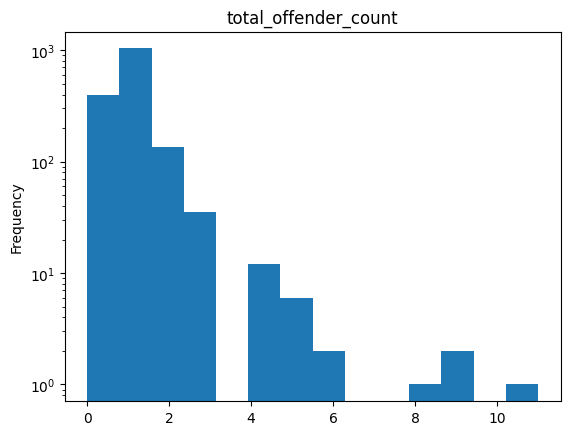

In [44]:
crime_df['total_offender_count'].plot.hist(bins=14, title='total_offender_count', logy=True)

<Axes: title={'center': 'adult_victim_count'}, ylabel='Frequency'>

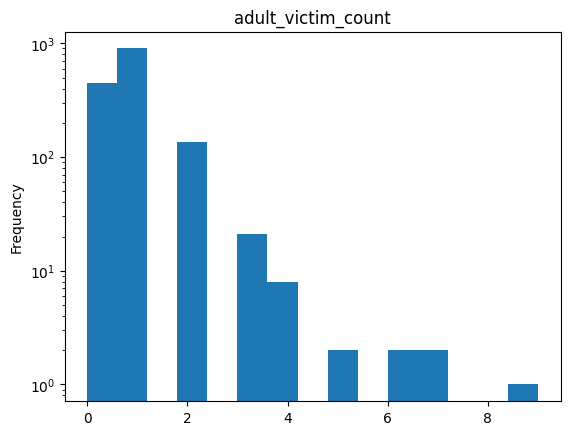

In [45]:
crime_df['adult_victim_count'].plot.hist(bins=15, title='adult_victim_count', logy=True)

<Axes: title={'center': 'juvenile_victim_count'}, ylabel='Frequency'>

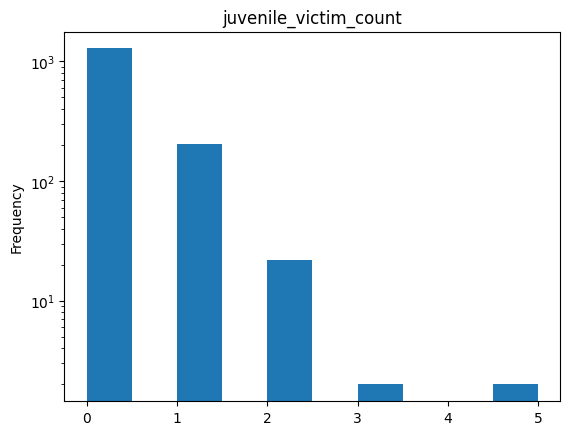

In [46]:
crime_df['juvenile_victim_count'].plot.hist(bins=10, title='juvenile_victim_count', logy=True)

####Categorical variable figures


In [47]:
def plot_column_counts(df, column_name, unique_values, title_phrase, figsize=(20, 5), rotation=90):
    # Create a dictionary of unique values and their counts
    unique_value_counts = get_col_counts(df, unique_values)

    # Sort the dictionary by values in descending order
    sorted_value_counts = dict(sorted(unique_value_counts.items(), key=lambda item: item[1], reverse=True))

    # Create a bar chart of the sorted valuees and their counts
    plt.figure(figsize=figsize)
    sns.barplot(x=list(sorted_value_counts.keys()), y=list(sorted_value_counts.values()), log=True)

    # Set the title and labels
    plt.title("Frequency of " + title_phrase + " in Hate Crimes", fontsize=16)
    plt.xlabel(title_phrase, fontsize=14)
    plt.ylabel("Frequency (Log Scale)", fontsize=14)

    # Rotate the x-axis labels for readability
    plt.xticks(rotation=rotation)

    # Show the plot
    plt.show()


(array([0, 1, 2, 3]),
 [Text(0, 0, 'South'),
  Text(1, 0, 'West'),
  Text(2, 0, 'Midwest'),
  Text(3, 0, 'Northeast')])

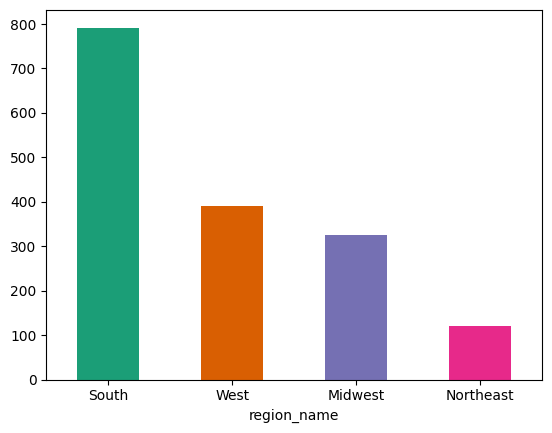

In [48]:
crime_df.groupby('region_name').size().sort_values(ascending=False).plot.bar(color=sns.palettes.mpl_palette('Dark2'))
plt.xticks(rotation=0)

<Axes: ylabel='offender_race'>

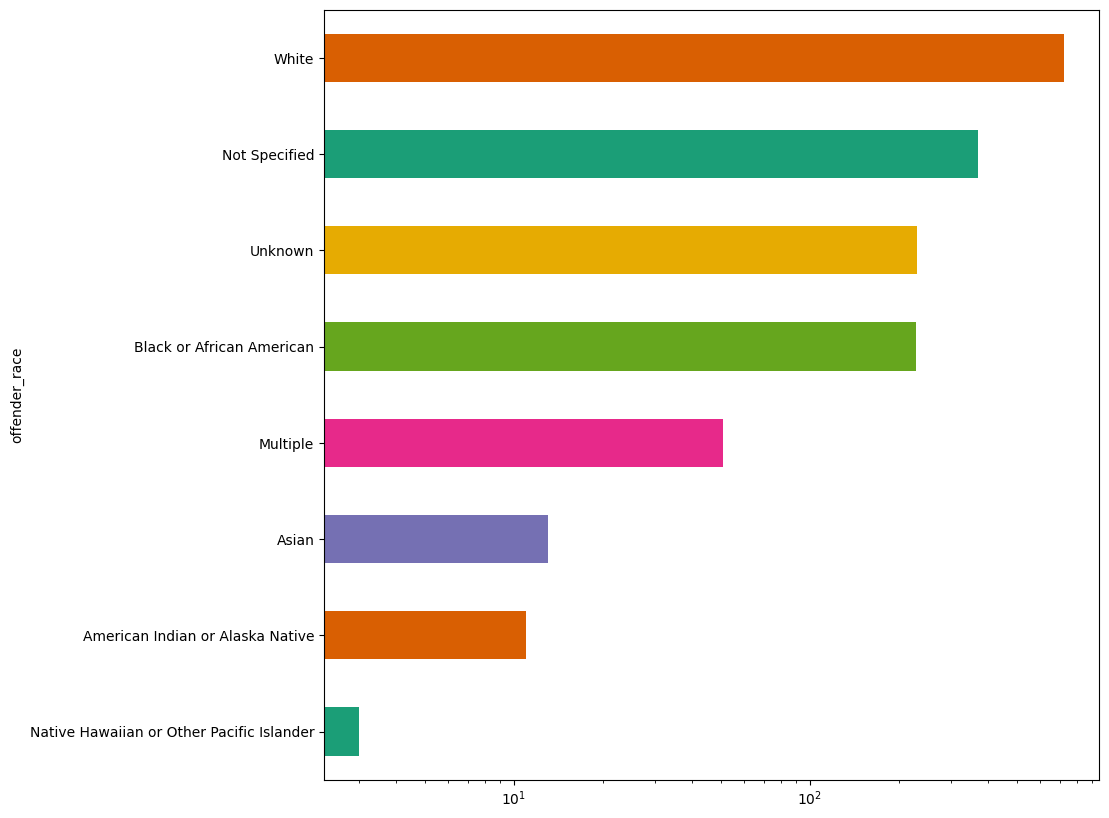

In [49]:
crime_df.groupby('offender_race').size().sort_values(ascending=True).plot.barh(color=sns.palettes.mpl_palette('Dark2'), figsize=(10,10), logx=True)

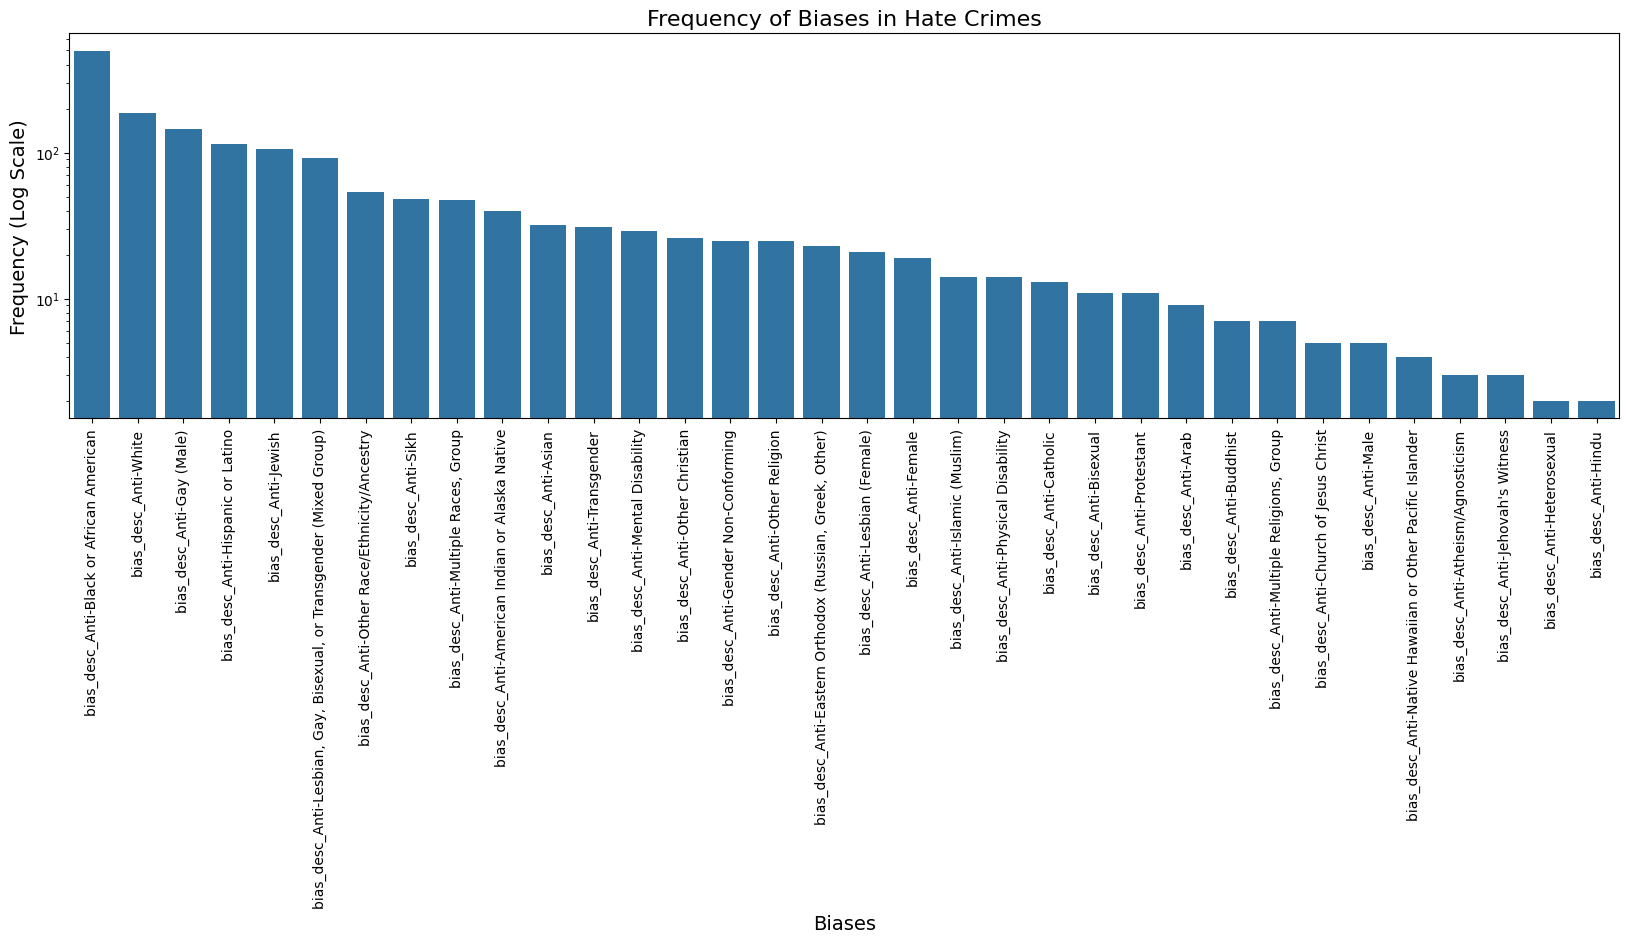

In [50]:
plot_column_counts(crime_df, "bias_desc", bias_cols, "Biases")

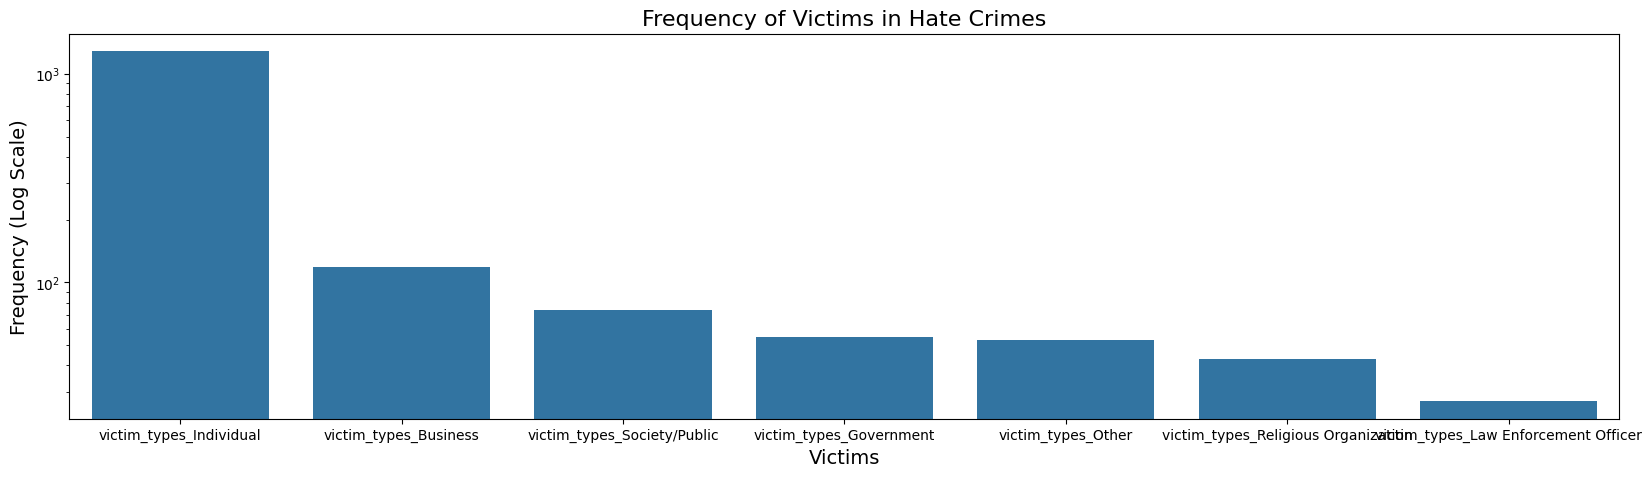

In [51]:
figsize=(20, 5)
plot_column_counts(crime_df, "victim_types", victim_cols, "Victims", figsize, 0)

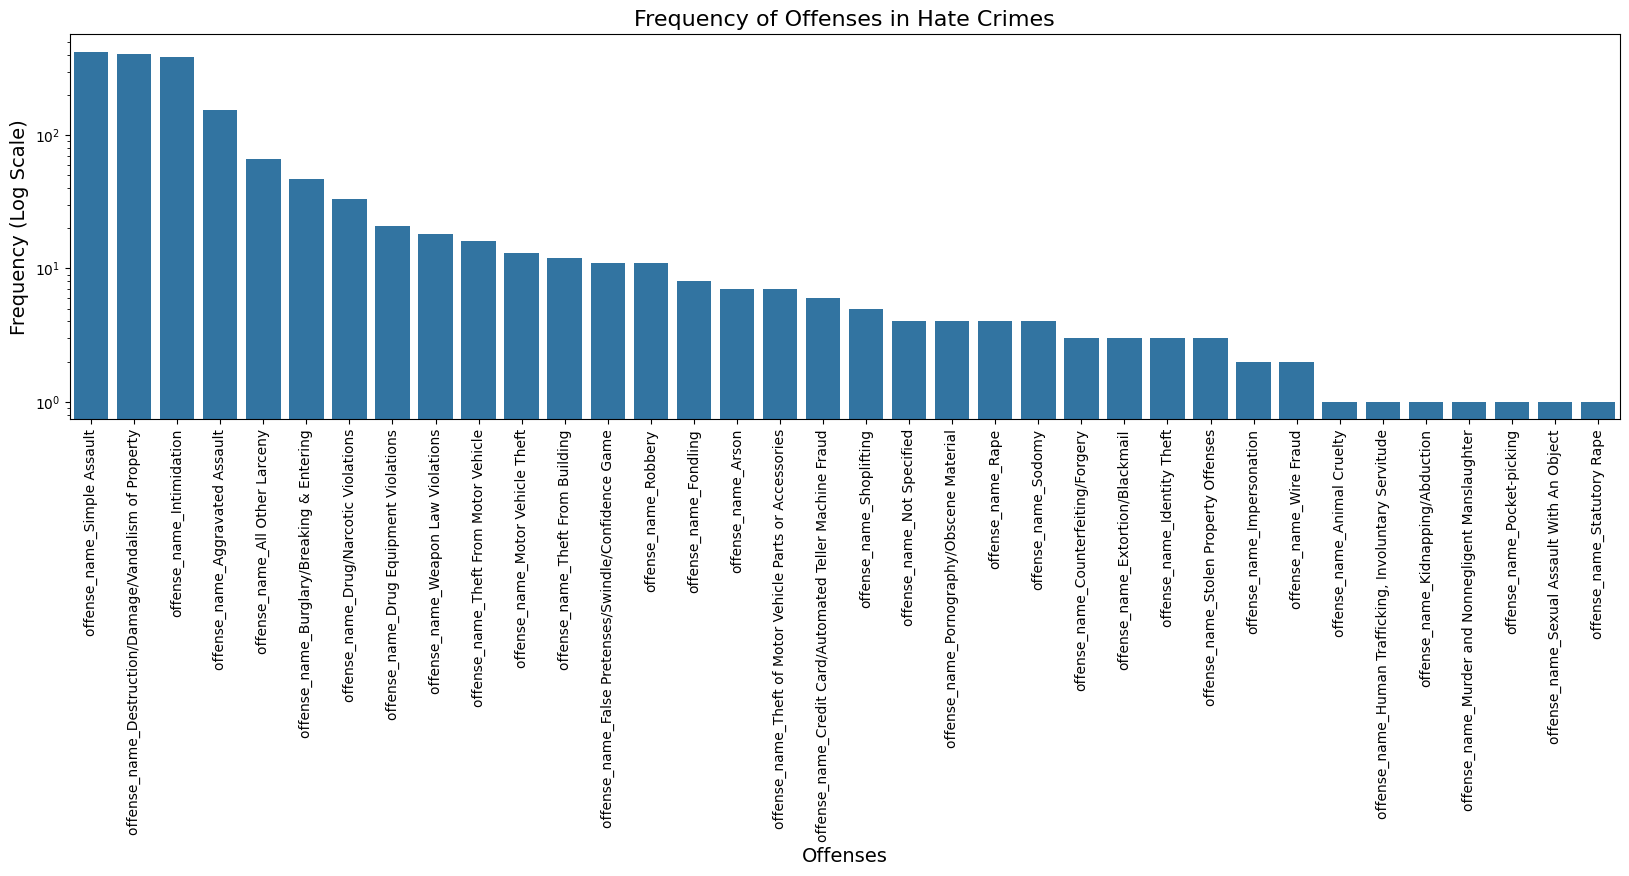

In [52]:
plot_column_counts(crime_df, "offense_name", offense_cols, "Offenses")

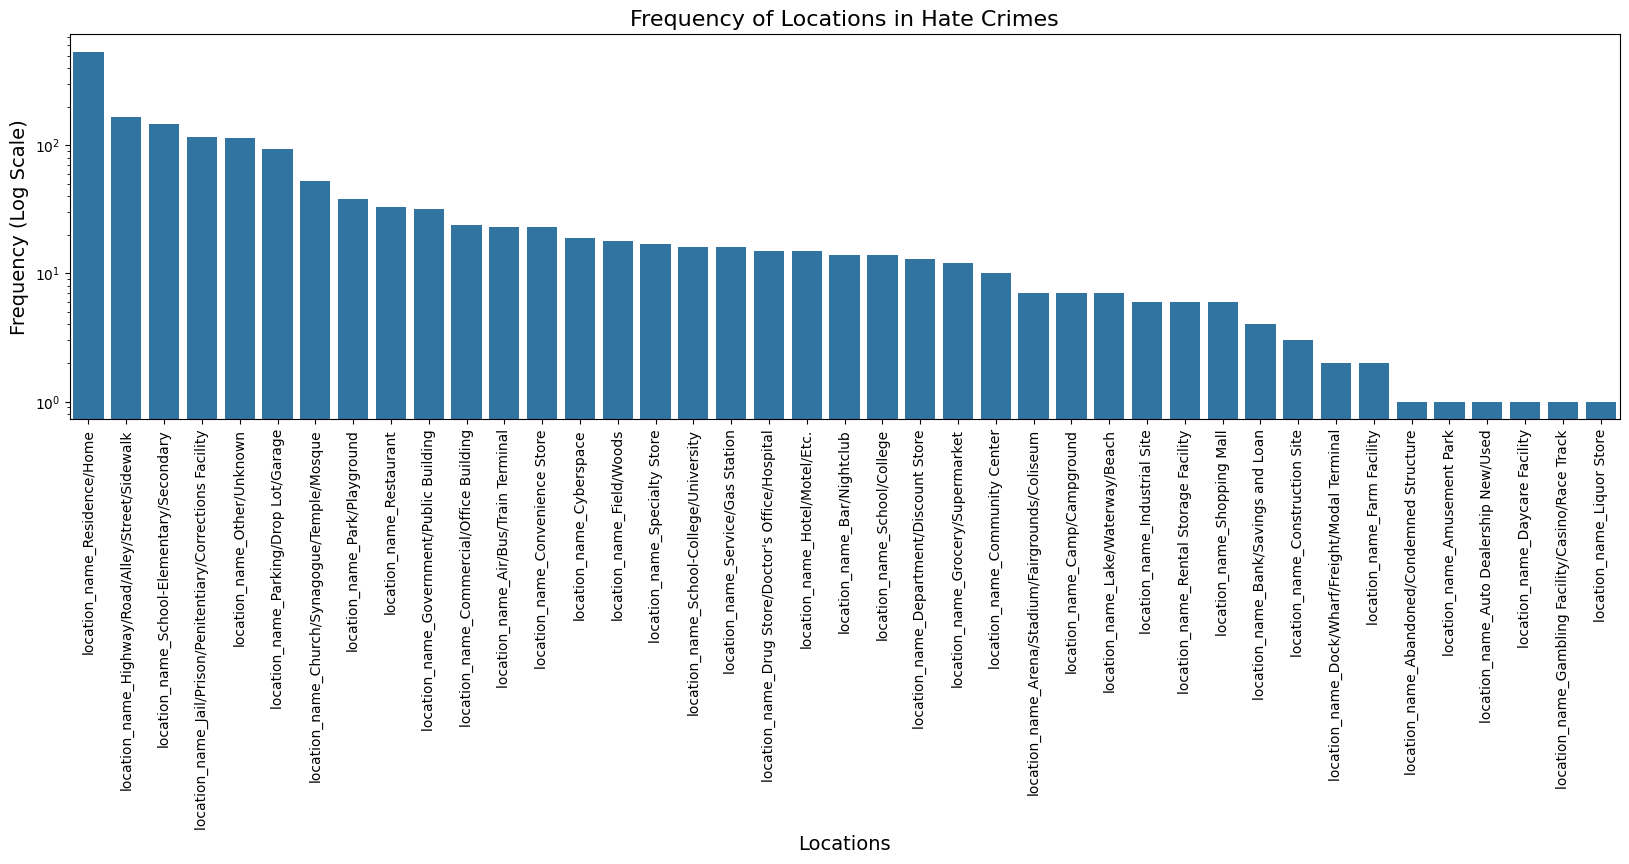

In [53]:
plot_column_counts(crime_df, "location_names", location_cols, "Locations")

####Geographic heat maps

In [54]:
ignore_list = ["Not Specified", "Unknown", "Multiple"]

Text(70.7222222222222, 0.5, 'Offender Race')

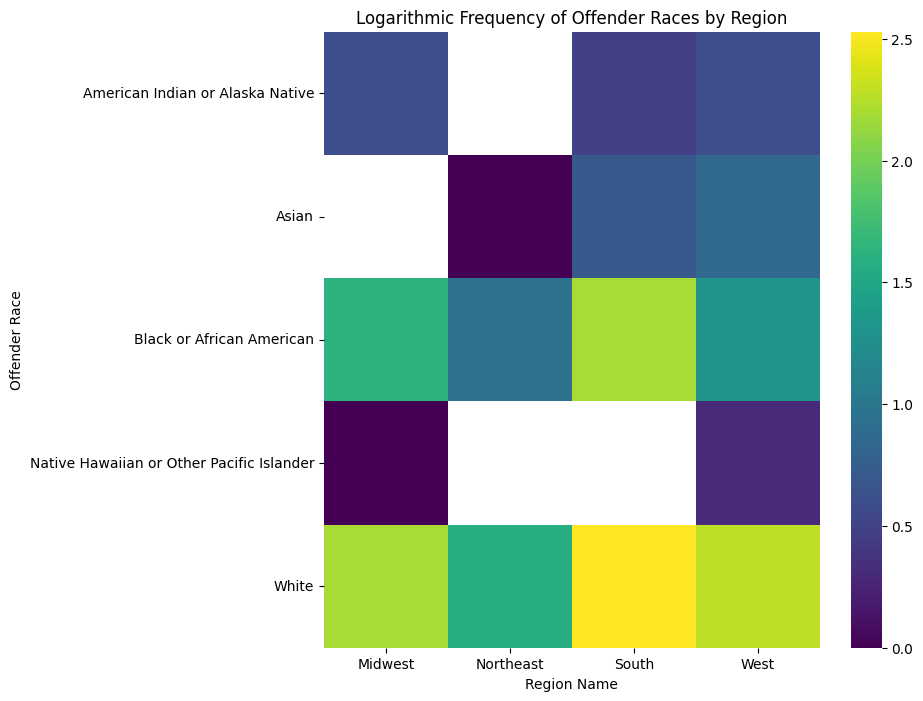

In [55]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['offender_race'].value_counts()
    for x_label, grp in crime_df.groupby('region_name')
})

# Drop less relevant columns for easier comparison with victim race heatmap
for item in ignore_list:
  df_2dhist.drop(item, inplace=True)

# Apply logarithmic transformation to the counts
df_2dhist_log = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

sns.heatmap(df_2dhist_log, cmap='viridis')
plt.title("Logarithmic Frequency of Offender Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Offender Race")

In [56]:
# Get some victim races to start with
unique_offender_races = crime_df['offender_race'].unique().tolist()

# Drop categories absent from victim data
for item in ignore_list:
  unique_offender_races.remove(item)

unique_victim_races = ["bias_desc_Anti-" + str(race) for race in unique_offender_races]

print(unique_victim_races)

['bias_desc_Anti-White', 'bias_desc_Anti-Black or African American', 'bias_desc_Anti-Asian', 'bias_desc_Anti-American Indian or Alaska Native', 'bias_desc_Anti-Native Hawaiian or Other Pacific Islander']


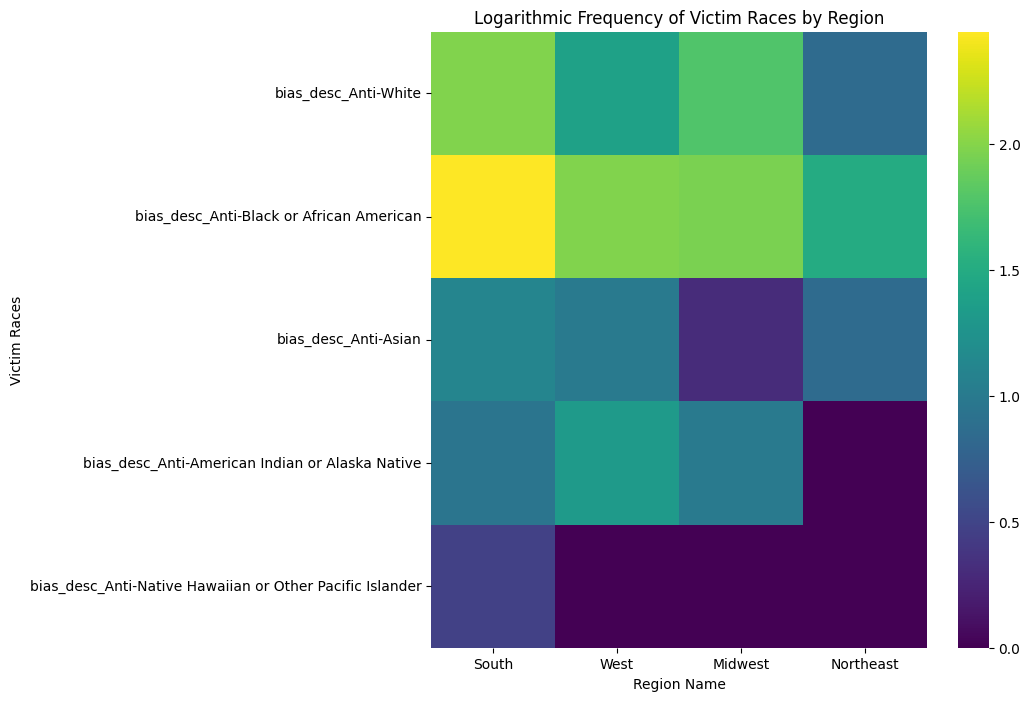

In [57]:
plt.subplots(figsize=(8, 8))

# Initialize an empty DataFrame with the correct index and columns
df_2dhist = pd.DataFrame(index=unique_victim_races, columns=crime_df['region_name'].unique())

# Iterate over each region and calculate the value counts for each victim race
for region in df_2dhist.columns:
    region_data = crime_df[crime_df['region_name'] == region]

    for victim_race in unique_victim_races:
        # Sum of occurrences of victim_race in the region
        count = region_data[victim_race].sum()
        # Update the DataFrame cell with the count
        df_2dhist.loc[victim_race, region] = count

# Convert DataFrame entries to numeric type and drop nan values
df_2dhist = df_2dhist.apply(pd.to_numeric)

# Apply logarithmic transformation to the counts
df_2dhist = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

# Create the heatmap with logarithmic scale
sns.heatmap(df_2dhist, cmap='viridis')

# Give the plot a title and axis labels
plt.title("Logarithmic Frequency of Victim Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Victim Races")
plt.yticks(rotation=0)

plt.show()

###County Demographics Dataset

In [58]:
county_demo_df.head()

,Geography,Geographic Area Name,Total population,Male,Female,Sex ratio (males per 100 females),Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 59 years,60 to 64 years,65 to 74 years,75 to 84 years,85 years and over,Median age (years),Under 18 years,16 years and over,21 years and over,62 years and over,18 years and over,18 years and over!!Male,18 years and over!!Female,18 years and over!!Sex ratio (males per 100 females),65 years and over,65 years and over!!Male,65 years and over!!Female,65 years and over!!Sex ratio (males per 100 females),RACE!!Total population,RACE!!One race,RACE!!One race!!White,RACE!!One race!!Black or African American,RACE!!One race!!American Indian and Alaska Native,RACE!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping,RACE!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping,RACE!!One race!!American Indian and Alaska Native!!Navajo tribal grouping,RACE!!One race!!American Indian and Alaska Native!!Sioux tribal grouping,RACE!!One race!!Asian,RACE!!One race!!Asian!!Asian Indian,RACE!!One race!!Asian!!Chinese,RACE!!One race!!Asian!!Filipino,RACE!!One race!!Asian!!Japanese,RACE!!One race!!Asian!!Korean,RACE!!One race!!Asian!!Vietnamese,RACE!!One race!!Asian!!Other Asian,RACE!!One race!!Native Hawaiian and Other Pacific Islander,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Chamorro,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Native Hawaiian,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Samoan,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Other Native Hawaiian and Other Pacific Islander,RACE!!One race!!Some Other Race,RACE!!Two or More Races,RACE!!Two or More Races!!White and Black or African American,RACE!!Two or More Races!!White and American Indian and Alaska Native,RACE!!Two or More Races!!White and Asian,RACE!!Two or More Races!!White and Some Other Race,RACE!!Two or More Races!!Black or African American and American Indian and Alaska Native,RACE!!Two or More Races!!Black or African American and Some Other Race,Race alone or in combination with one or more other races!!Total population,Race alone or in combination with one or more other races!!White,Race alone or in combination with one or more other races!!Black or African American,Race alone or in combination with one or more other races!!American Indian and Alaska Native,Race alone or in combination with one or more other races!!Asian,Race alone or in combination with one or more other races!!Native Hawaiian and Other Pacific Islander,Race alone or in combination with one or more other races!!Some Other Race,HISPANIC OR LATINO AND RACE!!Total population,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race),HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Puerto Rican,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Other Hispanic or Latino,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!White alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Black or African American alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!American Indian and Alaska Native alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Asian alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Some Other Race alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races including Some Other Race,"HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races excluding Some Other Race, and three or more races",Total housing units,"Citizen, 18 an

####Correlation matrix

In [59]:
county_numerical_cols = list(county_demo_df.select_dtypes(include=["int64", "float64"]).columns)

In [60]:
# Create a correlation matrix
county_corr = county_demo_df[county_numerical_cols].corr()

In [61]:
# Set the figure size
plt.figure(figsize=(100, 50))

# Create a heatmap of the correlation matrix
sns.heatmap(county_corr, annot=True)

# Show the plot
plt.show()

Output hidden; open in https://colab.research.google.com to view.

####Other figures

<Axes: xlabel='Under 5 years', ylabel='85 years and over'>

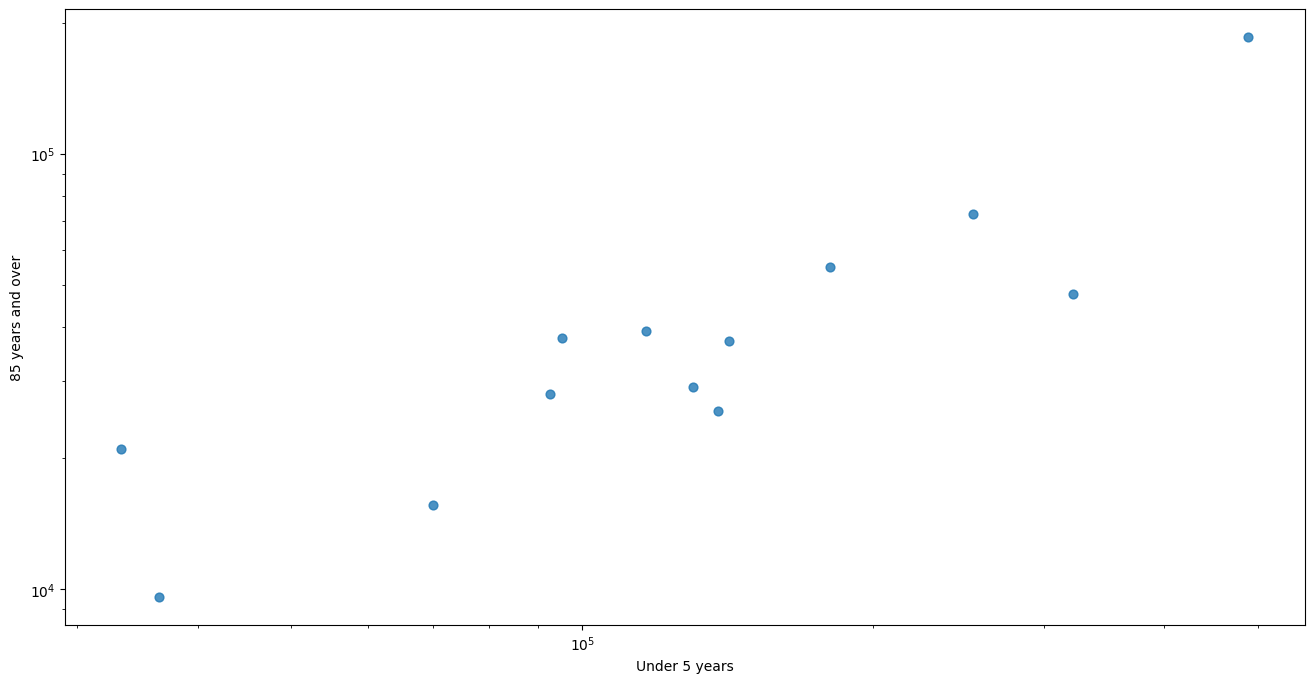

In [62]:
county_demo_df.plot.scatter(x='Under 5 years', y='85 years and over', logx=True, logy=True, s=40, alpha=.8, figsize=(16,8))

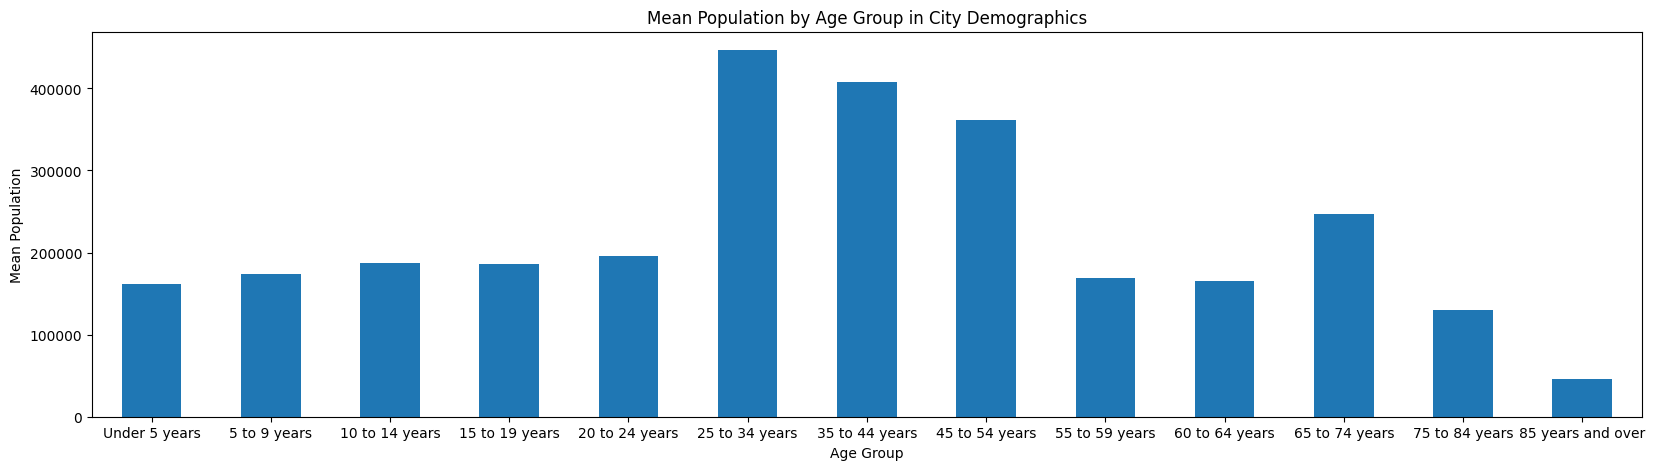

In [63]:
county_demo_df[age_groups].mean().plot.bar(figsize=(20,5))
plt.xlabel('Age Group')
plt.ylabel('Mean Population')
plt.title('Mean Population by Age Group in City Demographics')
plt.xticks(rotation=0)
plt.show()

##Merged Dataset

In [64]:
merged_df.head()

,index,incident_id,data_year,region_name,adult_victim_count,juvenile_victim_count,total_offender_count,adult_offender_count,juvenile_offender_count,victim_count,offense_name,total_individual_victims,incident_month,incident_day,bias_desc_Anti-American Indian or Alaska Native,bias_desc_Anti-Arab,bias_desc_Anti-Asian,bias_desc_Anti-Atheism/Agnosticism,bias_desc_Anti-Bisexual,bias_desc_Anti-Black or African American,bias_desc_Anti-Buddhist,bias_desc_Anti-Catholic,bias_desc_Anti-Church of Jesus Christ,"bias_desc_Anti-Eastern Orthodox (Russian, Greek, Other)",bias_desc_Anti-Female,bias_desc_Anti-Gay (Male),bias_desc_Anti-Gender Non-Conforming,bias_desc_Anti-Heterosexual,bias_desc_Anti-Hindu,bias_desc_Anti-Hispanic or Latino,bias_desc_Anti-Islamic (Muslim),bias_desc_Anti-Jehovah's Witness,bias_desc_Anti-Jewish,bias_desc_Anti-Lesbian (Female),"bias_desc_Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)",bias_desc_Anti-Male,bias_desc_Anti-Mental Disability,"bias_desc_Anti-Multiple Races, Group","bias_desc_Anti-Multiple Religions, Group",bias_desc_Anti-Native Hawaiian or Other Pacific Islander,bias_desc_Anti-Other Christian,bias_desc_Anti-Other Race/Ethnicity/Ancestry,bias_desc_Anti-Other Religion,bias_desc_Anti-Physical Disability,bias_desc_Anti-Protestant,bias_desc_Anti-Sikh,bias_desc_Anti-Transgender,bias_desc_Anti-White,victim_types_Business,victim_types_Government,victim_types_Individual,victim_types_Law Enforcement Officer,victim_types_Other,victim_types_Religious Organization,victim_types_Society/Public,offense_name_Aggravated Assault,offense_name_All Other Larceny,offense_name_Animal Cruelty,offense_name_Arson,offense_name_Burglary/Breaking & Entering,offense_name_Counterfeiting/Forgery,offense_name_Credit Card/Automated Teller Machine Fraud,offense_name_Destruction/Damage/Vandalism of Property,offense_name_Drug Equipment Violations,offense_name_Drug/Narcotic Violations,offense_name_Extortion/Blackmail,offense_name_False Pretenses/Swindle/Confidence Game,offense_name_Fondling,"offense_name_Human Trafficking, Involuntary Servitude",offense_name_Identity Theft,offense_name_Impersonation,offense_name_Intimidation,offense_name_Kidnapping/Abduction,offense_name_Motor Vehicle Theft,offense_name_Murder and Nonnegligent Manslaughter,offense_name_Not Specified,offense_name_Pocket-picking,offense_name_Pornography/Obscene Material,offense_name_Rape,offense_name_Robbery,offense_name_Sexual Assault With An Object,offense_name_Shoplifting,offense_name_Simple Assault,offense_name_Sodomy,offense_name_Statutory Rape,offense_name_Stolen Property Offenses,offense_name_Theft From Building,offense_name_Theft From Motor Vehicle,offense_name_Theft of Motor Vehicle Parts or Accessories,offense_name_Weapon Law Violations,offense_name_Wire Fraud,location_name_Abandoned/Condemned Structure,location_name_Air/Bus/Train Terminal,location_name_Amusement Park,location_name_Arena/Stadium/Fairgrounds/Coliseum,location_name_Auto Dealership New/Used,location_name_Bank/Savings and Loan,location_name_Bar/Nightclub,location_name_Camp/Campground,location_name_Church/Synagogue/Temple/Mosque,location_name_Commercial/Office Building,location_name_Community Center,location_name_Construction Site,location_name_Convenience Store,location_name_Cyberspace,location_name_Daycare Facility,location_name_Department/Discount Store,location_name_Dock/Wharf/Freight/Modal Terminal,location_name_Drug Store/Doctor's Office/Hospital,location_name_Farm Facility,location_name_Field/Woods,location_name_Gambling Facility/Casino/Race Track,location_name_Government/Public Building,location_name_Grocery/Supermarket,location_name_Highway/Road/Alley/Street/Sidewalk,location_name_Hotel/Motel/Etc.,location_name_Industrial Site,location_name_Jail/Prison/Penitentiary/Corrections Facility,location_name_Lake/Waterway/Beach,location_name_Liquor Store,location_name_Other/Unknown,location_name_Park/Playground,location_name_Parking/Drop Lot/Garage,location_name_Rental Storage Facility,location_name

###Correlation Matrix Analysis

In [104]:
#convert the categorical columns to numerical ones and store the modified df as a new df for correlation analysis
categorical_to_int_df = merged_df\
                          .select_dtypes(include=['int64', 'float64', np.number])\
                          .drop(labels=["index", "incident_id"], axis=1)
# Select only the numerical columns
numerical_cols = list(categorical_to_int_df.columns)
# numerical_cols

In [107]:
# Create a correlation matrix
merged_corr = merged_df[numerical_cols].corr()

###Correlation matrix preprocessing

In [110]:
# Unstack and rename merged_corr
merged_corr_sorted = pd.DataFrame(merged_corr.unstack()).reset_index()
merged_corr_sorted.rename(columns={"level_0":"feature1", "level_1":"feature2", 0:"corr"}, inplace=True)
merged_corr_sorted.head()

,feature1,feature2,corr
0,data_year,data_year,NaN
1,data_year,adult_victim_count,NaN
2,data_year,juvenile_victim_count,NaN
3,data_year,total_offender_count,NaN
4,data_year,adult_offender_count,NaN


In [111]:
merged_corr_sorted["abs_corr"] = 0

# Get highest correlation coefficient pairs
merged_corr_sorted["abs_corr"] = merged_corr_sorted["corr"].abs()
merged_corr_sorted.sort_values(by="abs_corr", ascending=False, inplace=True)

#reset the indices
merged_corr_sorted.reset_index(inplace=True)

merged_corr_sorted.head()

,index,feature1,feature2,corr,abs_corr
0,307,adult_victim_count,adult_victim_count,1.0,1.0
1,44515,offender_race_White,offender_race_White,1.0,1.0
2,43907,offender_race_Not Specified,offender_ethnicity_Not Specified,1.0,1.0
3,43901,offender_race_Not Specified,offender_race_Not Specified,1.0,1.0
4,43287,offender_race_Multiple,offender_race_Multiple,1.0,1.0


In [126]:
# remove coefficients that represent variables' correlations with themselves
#   and remove feature correlations with other features from the same set (which were reviewed in the individual dataset explorations above)
county_cols = list(county_numerical_cols)
crime_cols = list(crime_numerical_columns)

merged_corr_sorted = merged_corr_sorted[~(
    (merged_corr_sorted["feature1"] == merged_corr_sorted["feature2"])\
    | ((merged_corr_sorted["feature1"].isin(county_cols))
      & (merged_corr_sorted["feature2"].isin(county_cols)))
    | ((merged_corr_sorted["feature1"].isin(crime_cols))
      & (merged_corr_sorted["feature2"].isin(crime_cols)))
)]

In [127]:
merged_corr_sorted.head()

,index,feature1,feature2,corr,abs_corr
1101,58678,state_name_Washington,Percent!!25 to 34 years,0.964872,0.964872
1102,71183,Percent!!25 to 34 years,state_name_Washington,0.964872,0.964872
1125,90404,Percent!!HISPANIC OR LATINO AND RACE!!Not Hisp...,division_name_Pacific,-0.962666,0.962666
1126,41299,division_name_Pacific,Percent!!HISPANIC OR LATINO AND RACE!!Not Hisp...,-0.962666,0.962666
1127,42217,division_name_West South Central,Percent!!HISPANIC OR LATINO AND RACE!!Not Hisp...,0.962666,0.962666


<Axes: title={'center': 'Correlation Coefficient Frequency Distribution'}, ylabel='Frequency'>

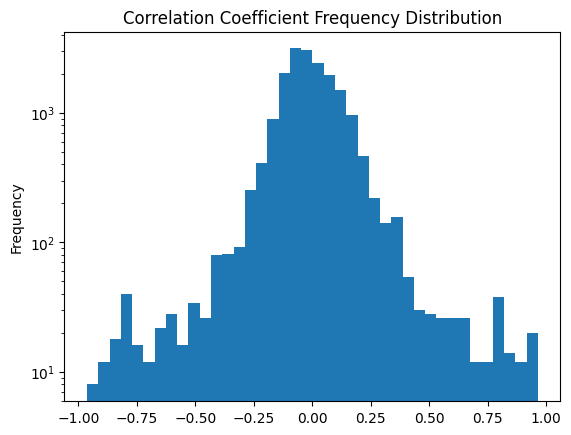

In [128]:
merged_corr_sorted['corr'].plot.hist(bins=40, title='Correlation Coefficient Frequency Distribution', logy=True)

<Axes: title={'center': 'Absolute Correlation Coefficient Frequency Distribution'}, ylabel='Frequency'>

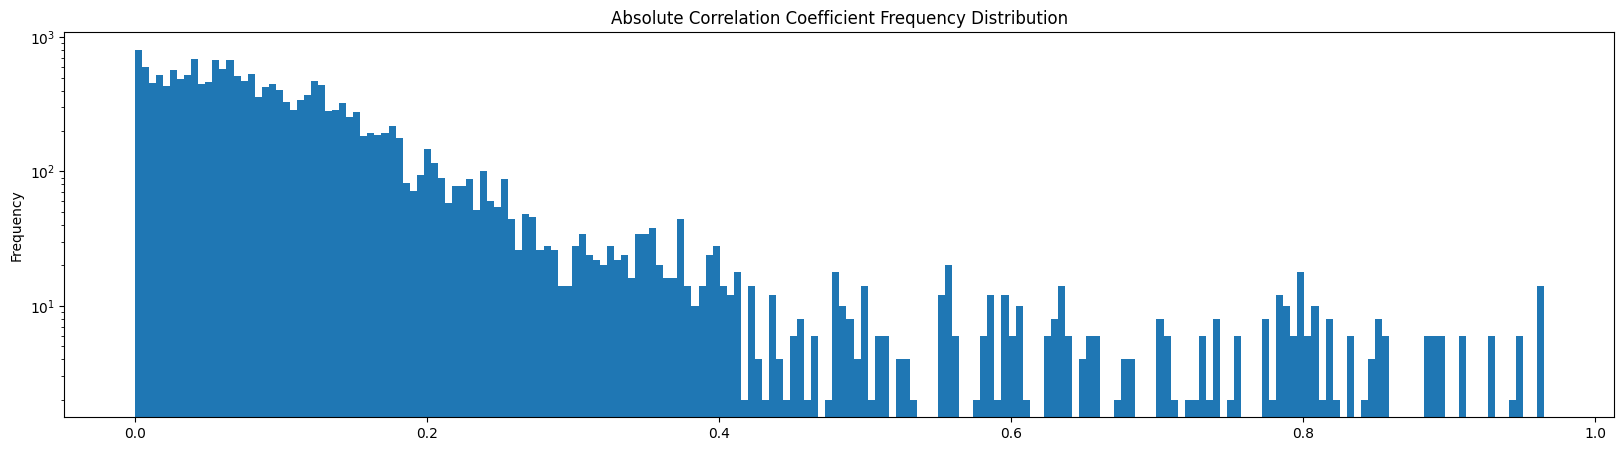

In [129]:
merged_corr_sorted['abs_corr'].plot.hist(bins=200, title='Absolute Correlation Coefficient Frequency Distribution', logy=True, figsize=(20, 5))

In [139]:
# drop half the entries, which are essentially duplicates,
#   as well as any np.nan entries and entries with low correlation coefficients or exceedingly high correlation coefficients,
#   which have already been considered previously or present trivial correlation information
#   (ie the number of individuals under 5 years of age is directly correlated with the total population)
merged_corrs_of_interest = merged_corr_sorted[
                              (merged_corr_sorted.index % 2 == 0)\
                              & (merged_corr_sorted["abs_corr"] > 0.2)
]

In [140]:
# Drop merged_corrs_of_interest entries that have "state_name" in feature1 or feature2
merged_corrs_of_interest = merged_corrs_of_interest[~merged_corrs_of_interest["feature1"].str.contains("state_name|division_name")]
merged_corrs_of_interest = merged_corrs_of_interest[~merged_corrs_of_interest["feature2"].str.contains("state_name|division_name")]

In [141]:
merged_corrs_of_interest

,index,feature1,feature2,corr,abs_corr
4614,37597,location_name_School-College/University,Percent!!RACE!!One race!!Asian!!Vietnamese,0.603167,0.603167
6286,44345,offender_race_Unknown,Percent!!Race alone or in combination with one...,-0.527293,0.527293
6348,37591,location_name_School-College/University,Percent!!RACE!!One race!!Asian,0.524424,0.524424
6354,91004,Percent!!HISPANIC OR LATINO AND RACE!!Not Hisp...,location_name_School-College/University,0.524037,0.524037
6636,79682,Percent!!RACE!!One race!!Asian!!Asian Indian,location_name_School-College/University,0.504299,0.504299
6808,37616,location_name_School-College/University,Percent!!Race alone or in combination with one...,0.494304,0.494304
6888,71447,Percent!!35 to 44 years,offender_ethnicity_Not Specified,0.489046,0.489046
6890,43991,offender_race_Not Specified,Percent!!35 to 44 years,0.489046,0.489046
7062,44316,offender_race_Unknown,Percent!!RACE!!One race!!White,-0.480008,0.480008
7120,37593,location_name_School-College/University,Percent!!RACE!!One race!!Asian!!Chinese,0.475640,0.475640


<Axes: title={'center': 'Frequency of potentially interesting correlation coefficients'}, ylabel='Frequency'>

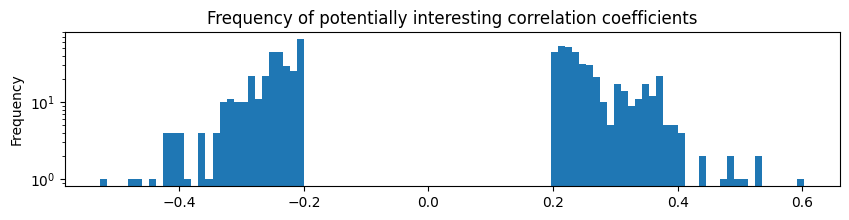

In [144]:
merged_corrs_of_interest['corr'].plot.hist(bins=100, title='Frequency of potentially interesting correlation coefficients', logy=True, figsize=(10, 2))